In [1]:
import re
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
url = "https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/refs/heads/main/B2W-Reviews01.csv"
df = pd.read_csv(url)
df.head()

/tmp/ipython-input-667451803.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,F,SP
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,M,MG


In [3]:
def clean_text(text):
    text = str(text).lower()
    text = text.replace("lojas americanas", "loja")
    text = text.replace("americanas", "loja")
    text = text.replace("americana", "loja")
    text = re.sub(r"r?\$ ?\d+([.,]\d+)?", "dinheiro", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\S+", "", text)
    text = re.sub(r"[^a-z0-9à-úç ]", "", text)
    text = " ".join(text.split())
    return text

nltk.download("stopwords")
stop_pt = stopwords.words("portuguese")

df = df.replace({'recommend_to_a_friend': {'Yes': 'Positivo', 'No': 'Negativo'}})
df = df[['review_text', 'recommend_to_a_friend']]
df.dropna(subset=['review_text', 'recommend_to_a_friend'], inplace=True)
df['review_text'] = df['review_text'].astype(str).apply(clean_text)

X = df['review_text']
y = df['recommend_to_a_friend']

print(y.value_counts(normalize=False))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


recommend_to_a_friend
Positivo    95066
Negativo    34014
Name: count, dtype: int64


In [4]:
# Split com Stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Treino: {X_train.shape[0]} amostras | Teste: {X_test.shape[0]} amostras")

Treino: 90356 amostras | Teste: 38724 amostras


In [5]:
# Pipeline com TF-IDF + Naive Bayes
cachedir = mkdtemp()

pipeline = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer (stop_words=stop_pt, min_df=3)),
        ('clf', MultinomialNB())
    ],
    memory=cachedir
)

# Grid Search   MultinomialNB     ACURÁCIA: 0.8881
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

param_grid = {
    'tfidf__ngram_range': [(1,2)],
    'tfidf__max_features': [None],
    'tfidf__binary': [True],
    'tfidf__norm': ['l2'],
    'clf__alpha': [0.1, 1.0, 5.0],
    'clf__fit_prior': [True, False]
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)


print("Treinando GridSearch com Naive Bayes...")
grid.fit(X_train, y_train, clf__sample_weight=sample_weights)

print("Melhores parâmetros:", grid.best_params_)

In [16]:
# Grid Search
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

param_grid = {
    'tfidf__ngram_range': [(1,2)],
    'tfidf__max_features': [None],
    'tfidf__binary': [True],
    'tfidf__norm': ['l2'],
    'clf__alpha': [0.1],
    'clf__fit_prior': [True]
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)


print("Treinando GridSearch com Naive Bayes...")
grid.fit(X_train, y_train, clf__sample_weight=sample_weights)

print("Melhores parâmetros:", grid.best_params_)

Treinando GridSearch com Naive Bayes...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Melhores parâmetros: {'clf__alpha': 0.1, 'clf__fit_prior': True, 'tfidf__binary': True, 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2'}


In [17]:
# Avaliação
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print(f"\nACURÁCIA: {accuracy_score(y_test, y_pred):.4f}")
print("\nRELATÓRIO DE CLASSIFICAÇÃO:")
print(classification_report(y_test, y_pred))
#ACURÁCIA: 0.8741
#ACURÁCIA: 0.8881


ACURÁCIA: 0.8880

RELATÓRIO DE CLASSIFICAÇÃO:
              precision    recall  f1-score   support

    Negativo       0.74      0.89      0.81     10204
    Positivo       0.96      0.89      0.92     28520

    accuracy                           0.89     38724
   macro avg       0.85      0.89      0.86     38724
weighted avg       0.90      0.89      0.89     38724



In [18]:
# Salvar modelo
joblib.dump(best_model, 'modelo_sentimento_pt.joblib')
print("Modelo salvo como modelo_sentimento_pt.joblib")

Modelo salvo como modelo_sentimento_pt.joblib


In [9]:
import joblib

# Carregar o modelo (simulando o start da API)
print("Carregando modelo...")
try:
    pipeline = joblib.load('modelo_sentimento_pt.joblib')
    print("Modelo carregado com sucesso!")
except FileNotFoundError:
    print("Erro: Arquivo .joblib não encontrado.")
    exit()

# Dados de teste (Frases novas que o modelo nunca viu)
testes = [
    "O produto chegou quebrado e o atendimento foi rude.",  # Esperado: No/Negativo
    "Adorei a entrega, foi muito rápida e eficiente!",      # Esperado: Yes/Positivo
    "O serviço é normal, nada demais."                     # Esperado: Depende (Talvez No ou Yes)
]

# Fazer a predição
print("\n--- Teste de Inferência ---")
predicoes = pipeline.predict(testes)
probabilidades = pipeline.predict_proba(testes)

for texto, pred, prob in zip(testes, predicoes, probabilidades):
    # prob[0] é a chance da primeira classe, prob[1] da segunda.
    # O max(prob) pega a confiança da classe escolhida.
    confianca = max(prob)
    print(f"Texto: '{texto}'")
    print(f"Predição: {pred} | Confiança: {confianca:.2f}")
    print("-" * 30)

Carregando modelo...
Modelo carregado com sucesso!

--- Teste de Inferência ---
Texto: 'O produto chegou quebrado e o atendimento foi rude.'
Predição: Negativo | Confiança: 0.98
------------------------------
Texto: 'Adorei a entrega, foi muito rápida e eficiente!'
Predição: Positivo | Confiança: 1.00
------------------------------
Texto: 'O serviço é normal, nada demais.'
Predição: Negativo | Confiança: 0.71
------------------------------


In [10]:
testes = [
    # --- Fáceis (Positivo/Negativo Claros) ---
    "O produto chegou quebrado e o atendimento foi rude.",         # Esperado: Negativo
    "Adorei a entrega, foi muito rápida e eficiente!",             # Esperado: Positivo
    "O serviço é normal, nada demais.",                            # Esperado: Negativo (ou o modelo pode ficar confuso)
    "Simplesmente fantástico, superou minhas expectativas.",       # Esperado: Positivo
    "Horrível, nunca mais compro com vocês.",                      # Esperado: Negativo

    # --- Desafiadores (Sentimentos Mistos - uso do "Mas") ---
    "O produto é lindo, mas a entrega demorou uma eternidade.",    # Esperado: Negativo (geralmente a crítica final pesa mais)
    "A comida estava fria, porém o garçom foi muito educado.",     # Esperado: Positivo (ou confuso)

    # --- Gírias e Internetês ---
    "O atendimento foi top demais!",                               # Esperado: Positivo
    "Achei o material bem meia boca.",                             # Esperado: Negativo
    "Zero defeitos! Perfeito.",                                    # Esperado: Positivo

    # --- Sarcasmo (O "Chefão" para o modelo) ---
    "Parabéns pela incompetência, nota 0.",                        # Esperado: Negativo (contém palavra "Parabéns", pode confundir)
    "Maravilhoso... funcionou por exatos 5 minutos.",              # Esperado: Negativo

    # --- Curtas e Diretas ---
    "Lixo.",                                                       # Esperado: Negativo
    "Recomendo.",                                                  # Esperado: Positivo
    "Não.",                                                        # Esperado: Negativo
]

In [11]:
# Faz a previsão usando o pipeline completo
previsoes = pipeline.predict(testes)

# Mostra o resultado bonitinho
for frase, sentimento in zip(testes, previsoes):
    print(f"{sentimento} -> {frase}")

Negativo -> O produto chegou quebrado e o atendimento foi rude.
Positivo -> Adorei a entrega, foi muito rápida e eficiente!
Negativo -> O serviço é normal, nada demais.
Positivo -> Simplesmente fantástico, superou minhas expectativas.
Negativo -> Horrível, nunca mais compro com vocês.
Positivo -> O produto é lindo, mas a entrega demorou uma eternidade.
Positivo -> A comida estava fria, porém o garçom foi muito educado.
Positivo -> O atendimento foi top demais!
Negativo -> Achei o material bem meia boca.
Negativo -> Zero defeitos! Perfeito.
Negativo -> Parabéns pela incompetência, nota 0.
Negativo -> Maravilhoso... funcionou por exatos 5 minutos.
Negativo -> Lixo.
Positivo -> Recomendo.
Positivo -> Não.


In [12]:
# Pegar o modelo e o vetorizador de dentro do pipeline
classifier = pipeline.named_steps['clf']
vectorizer = pipeline.named_steps['tfidf']

# Obter nomes das features (palavras)
feature_names = vectorizer.get_feature_names_out()

# Obter as probabilidades logarítmicas para cada classe
# classifier.classes_ deve ser ['Negativo', 'Positivo']
log_prob_negativo = classifier.feature_log_prob_[0]
log_prob_positivo = classifier.feature_log_prob_[1]


# Calcular a diferença entre as probabilidades logarítmicas (Positivo - Negativo)
# Valores positivos indicam que a palavra puxa para 'Positivo'
# Valores negativos indicam que a palavra puxa para 'Negativo'
coefs = log_prob_positivo - log_prob_negativo

# Criar um DataFrame para visualizar
df_weights = pd.DataFrame({'palavra': feature_names, 'peso': coefs})

# Palavras que mais puxam para "Negativo" (Pesos mais negativos)
print("--- Top 50 palavras que indicam 'Negativo' ---")
print(df_weights.sort_values(by='peso').head(50))

# Palavras que mais puxam para "Positivo" (Pesos mais positivos)
print("\n--- Top 50 palavras que indicam 'Positivo' ---")
print(df_weights.sort_values(by='peso', ascending=False).head(50))

--- Top 20 palavras que indicam 'Negativo' ---
                     palavra      peso
21316        dinheiro jogado -6.181824
34330        joguei dinheiro -5.571511
53300         quero devolver -5.317040
40573           nao entregue -5.216336
54692      recomendo ninguem -4.953905
14883              compre dá -4.898985
63951               up2games -4.898985
22328            dá up2games -4.898985
66065        vergonhoso loja -4.894724
43513          parceria lixo -4.862675
21362    dinheiro vergonhoso -4.848898
56259         rouba dinheiro -4.848898
63952         up2games rouba -4.848898
54693      recomendo ninguém -4.809212
44028       pedido devolução -4.751091
58664  simplesmente funciona -4.730928
40521             nao compre -4.713295
52135        péssimo produto -4.701731
60647         tapete péssima -4.680497
29511           foto compara -4.680497
50637             produto má -4.645436
50854       produto quebrado -4.603773
40614             nao indico -4.581650
50718          pr

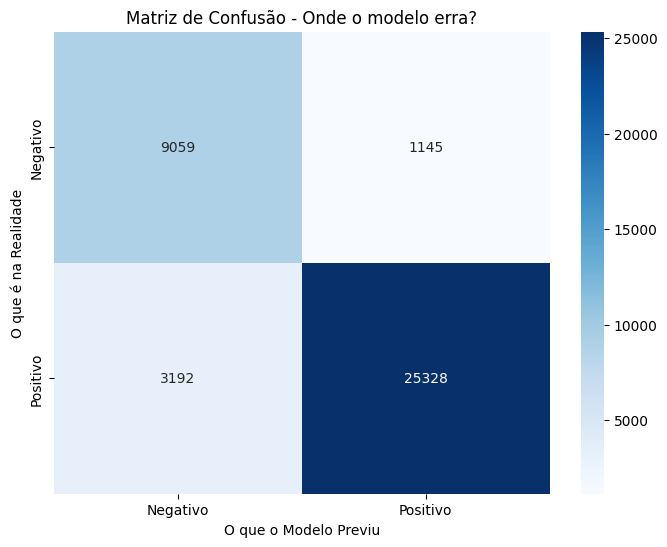

In [13]:
cm = confusion_matrix(y_test, grid.predict(X_test))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])

plt.xlabel('O que o Modelo Previu')
plt.ylabel('O que é na Realidade')
plt.title('Matriz de Confusão - Onde o modelo erra?')
plt.show()

In [14]:
previsoes = grid.predict(X_test)

# Cria um DataFrame temporário juntando Texto, Realidade e Previsão
# Isso facilita muito a filtragem visual
df_auditoria = pd.DataFrame({
    'Texto_Original': X_test,
    'Real': y_test,
    'Predito': previsoes
})

# FILTRO MÁGICO: Seleciona apenas o Canto Inferior Esquerdo da Matriz
# Queremos: Real == Positivo  E  Predito == Negativo
falsos_negativos = df_auditoria[
    (df_auditoria['Real'] == 'Positivo') &
    (df_auditoria['Predito'] == 'Negativo')
]

# Configura para mostrar o texto inteiro (sem cortar com '...')
pd.set_option('display.max_colwidth', None)

# Mostra 20 exemplos aleatórios
print(f"Total de erros desse tipo: {len(falsos_negativos)}")
print("--- Amostra de 20 Falsos Negativos (Era Bom, Modelo disse Ruim) ---")
display(falsos_negativos['Texto_Original'].sample(20))

Total de erros desse tipo: 3192
--- Amostra de 20 Falsos Negativos (Era Bom, Modelo disse Ruim) ---


,Texto_Original
24176,a principal característica do lg k10 o primeiro era seu design moderno sofisticado apesar de ser todo construído em plástico era um dos mais bonitos celulares disponíveis no mercado aí veio o k10 novo com várias melhorias no hardware mas com um design comum banal tentando ser sofisticado ele só conseguiu ser feio mesmo e sem gorilla glass ou seja caiu quebrou quanto ao preço deste produto na casa dos 700 reais me parece salgado o moto e4 é muito mais sofisticado com design verdadeiramente premium e custa menos
73920,que demoraaa cade esse celular meu deus vcs são muito enrolados no mercado livre chega em 3 dias
34948,acho q o vendedor deveria especificar o tamanho das caixas elas são mini 6cmx7cm para ter uma noção a caixa q vem as duas caixinhas mede 14cm isso seria a metade de uma régua escolar o som é bom a entrega da galditech está de parabéns pedi dia 3001 e recebi 0102
44469,muito bom porem o manual não consta o procedimento de acerto do relógio
33126,pelo preço esta bom até agora ainda não me deu problema
69271,meu pedido foi pago estou aguardando ele chegar até no momento não veio já paguei a entrega inspirou e o produto não veio
51245,comprei o produto mas não serviu no telefone nem cheguei a abrir mas é maior me enganei pela primeira foto infelizmente gostaria de trocar
113361,solução adequada e conviniente de como está a instalação hidráulica e elétrica do local
25213,oi eu queria saber se essa capinha serve tambem no zenfone 4 selfie
13125,bombombombom agora acho que o texto ficou mais longo


# Nova seção

In [15]:
from PIL import Image, ImageDraw, ImageFont
import os

# CAMINHOS
INPUT_PATH = "/mnt/data/ChatGPT Image 10 de dez. de 2025, 19_42_00.png"
OUTPUT_PATH = "/mnt/data/meme_expectativa_realidade_final.png"

# TEXTOS DO MEME
top_header = "EXPECTATIVA"
bottom_header = "REALIDADE"

top_caption = "Nova feature lançada"
bottom_caption = "Cliente reclamando da entrega e do atendimento"

# Carregar imagem
img = Image.open(INPUT_PATH).convert("RGB")
w, h = img.size
draw = ImageDraw.Draw(img)

# Carregar fontes (funciona no Colab)
def load_font(size, bold=False):
    try:
        if bold:
            return ImageFont.truetype(
                "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", size
            )
        else:
            return ImageFont.truetype(
                "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", size
            )
    except:
        return ImageFont.load_default()

header_font = load_font(int(h * 0.06), bold=True)
caption_font = load_font(int(h * 0.032))

# Função para texto centralizado
def draw_centered(text, y, font, color=(0,0,0)):
    text_w, text_h = draw.textsize(text, font=font)
    x = (w - text_w) // 2
    draw.text((x, y), text, fill=color, font=font)

# POSIÇÕES (ajustadas para esse layout)
draw_centered(top_header, int(h * 0.03), header_font)
draw_centered(top_caption, int(h * 0.28), caption_font)

draw_centered(bottom_header, int(h * 0.52), header_font)
draw_centered(bottom_caption, int(h * 0.80), caption_font)

# Salvar meme
img.save(OUTPUT_PATH)

OUTPUT_PATH


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/ChatGPT Image 10 de dez. de 2025, 19_42_00.png'

In [ ]:
import os

INPUT_PATH = '/mnt/data/ChatGPT Image 10 de dez. de 2025, 19_42_00.png'

if os.path.exists(INPUT_PATH):
    print(f"O arquivo '{INPUT_PATH}' existe.")
else:
    print(f"O arquivo '{INPUT_PATH}' NÃO existe. Verifique o caminho e o nome do arquivo.")